In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm
import os
import glob
import cv2
from PIL import Image
import pandas as pd
from torchmetrics import JaccardIndex
from datasets import load_dataset
from IPython.display import display
from torch.optim.lr_scheduler import CyclicLR, OneCycleLR, CosineAnnealingWarmRestarts, LinearLR
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics import JaccardIndex

 
from torchvision.transforms import v2
from torch.utils.data import DataLoader

/home/adminnio/miniconda3/envs/navigator/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True #False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
gpu_name = torch.cuda.get_device_name(device)
print(f"GPU Name: {gpu_name}")

Using device cuda:0
GPU Name: NVIDIA GeForce RTX 4090


In [3]:
from datasets import load_dataset
cache_directory = "/media/adminnio/Volume/Data/HuggingFace"
ds = load_dataset("EPFL-ECEO/coralscapes", cache_dir=cache_directory)


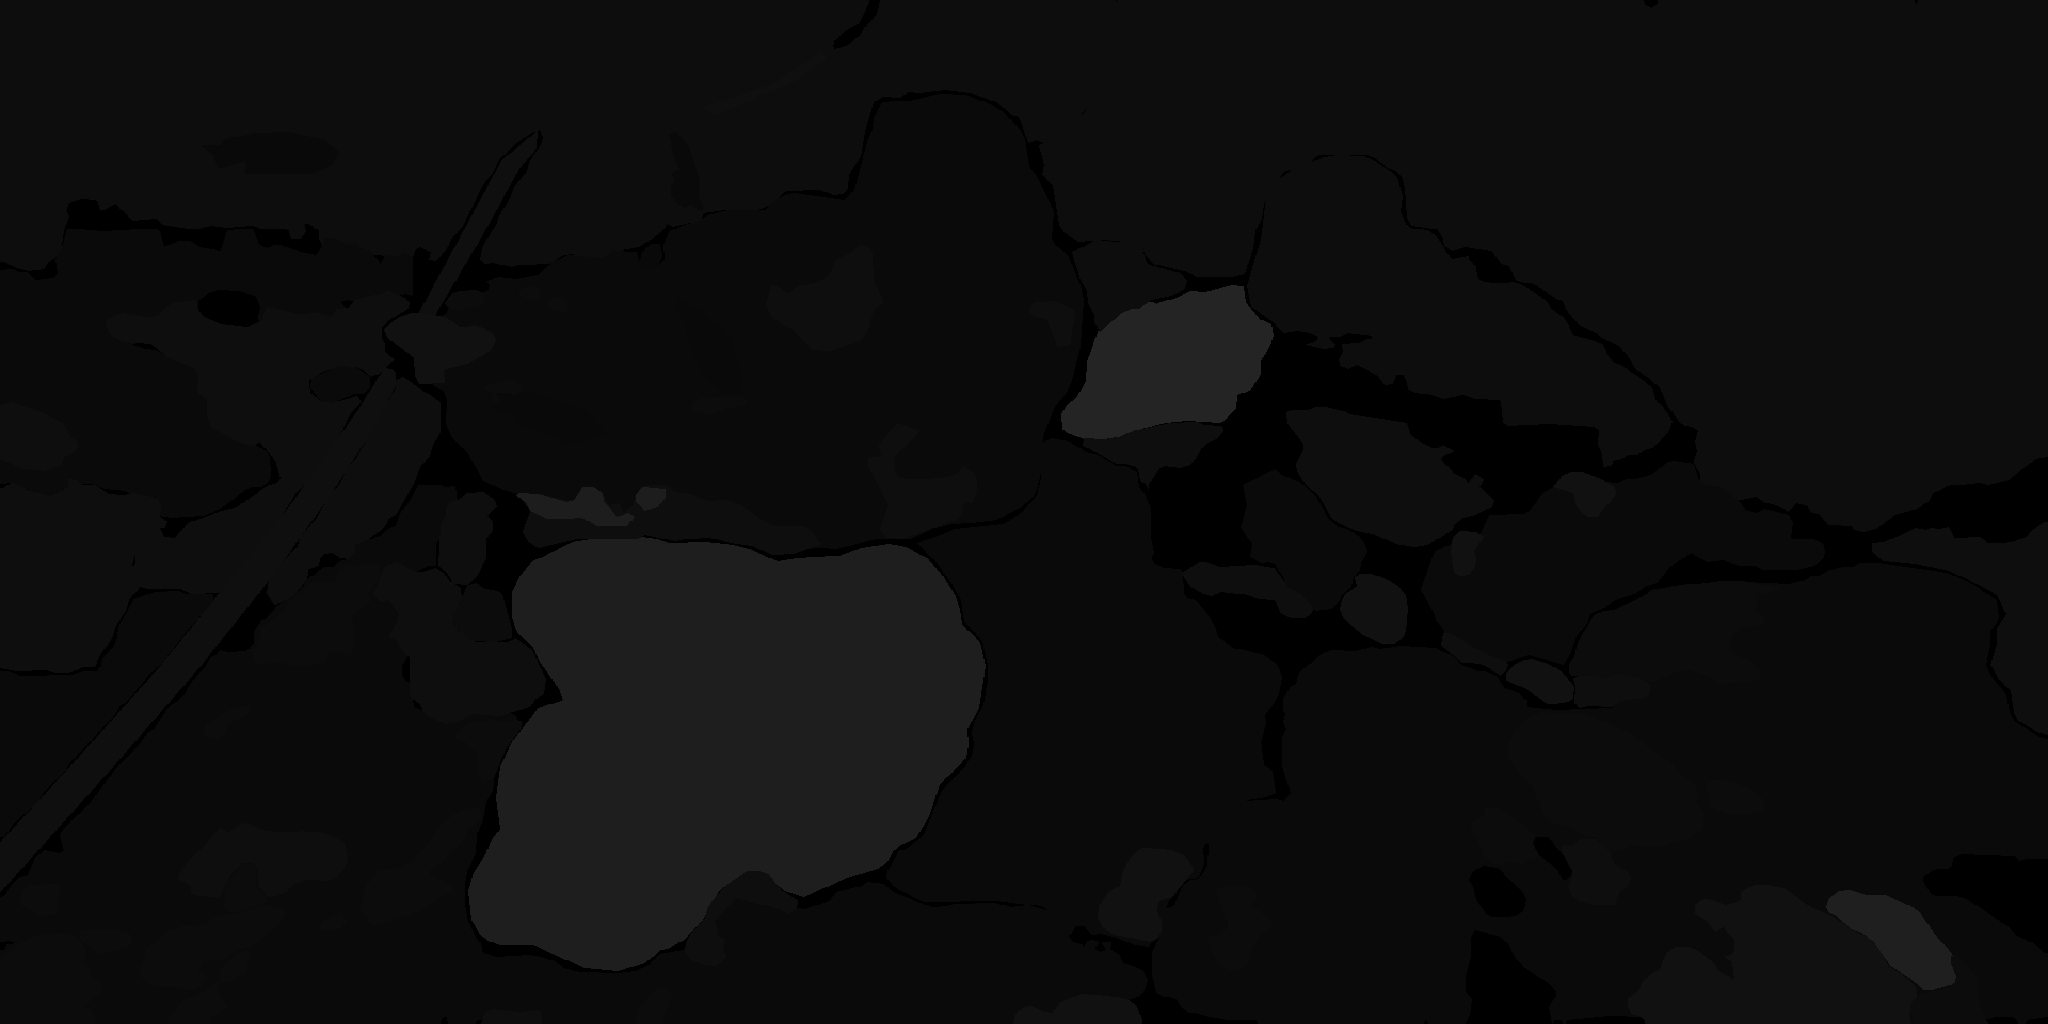

(1024, 2048)


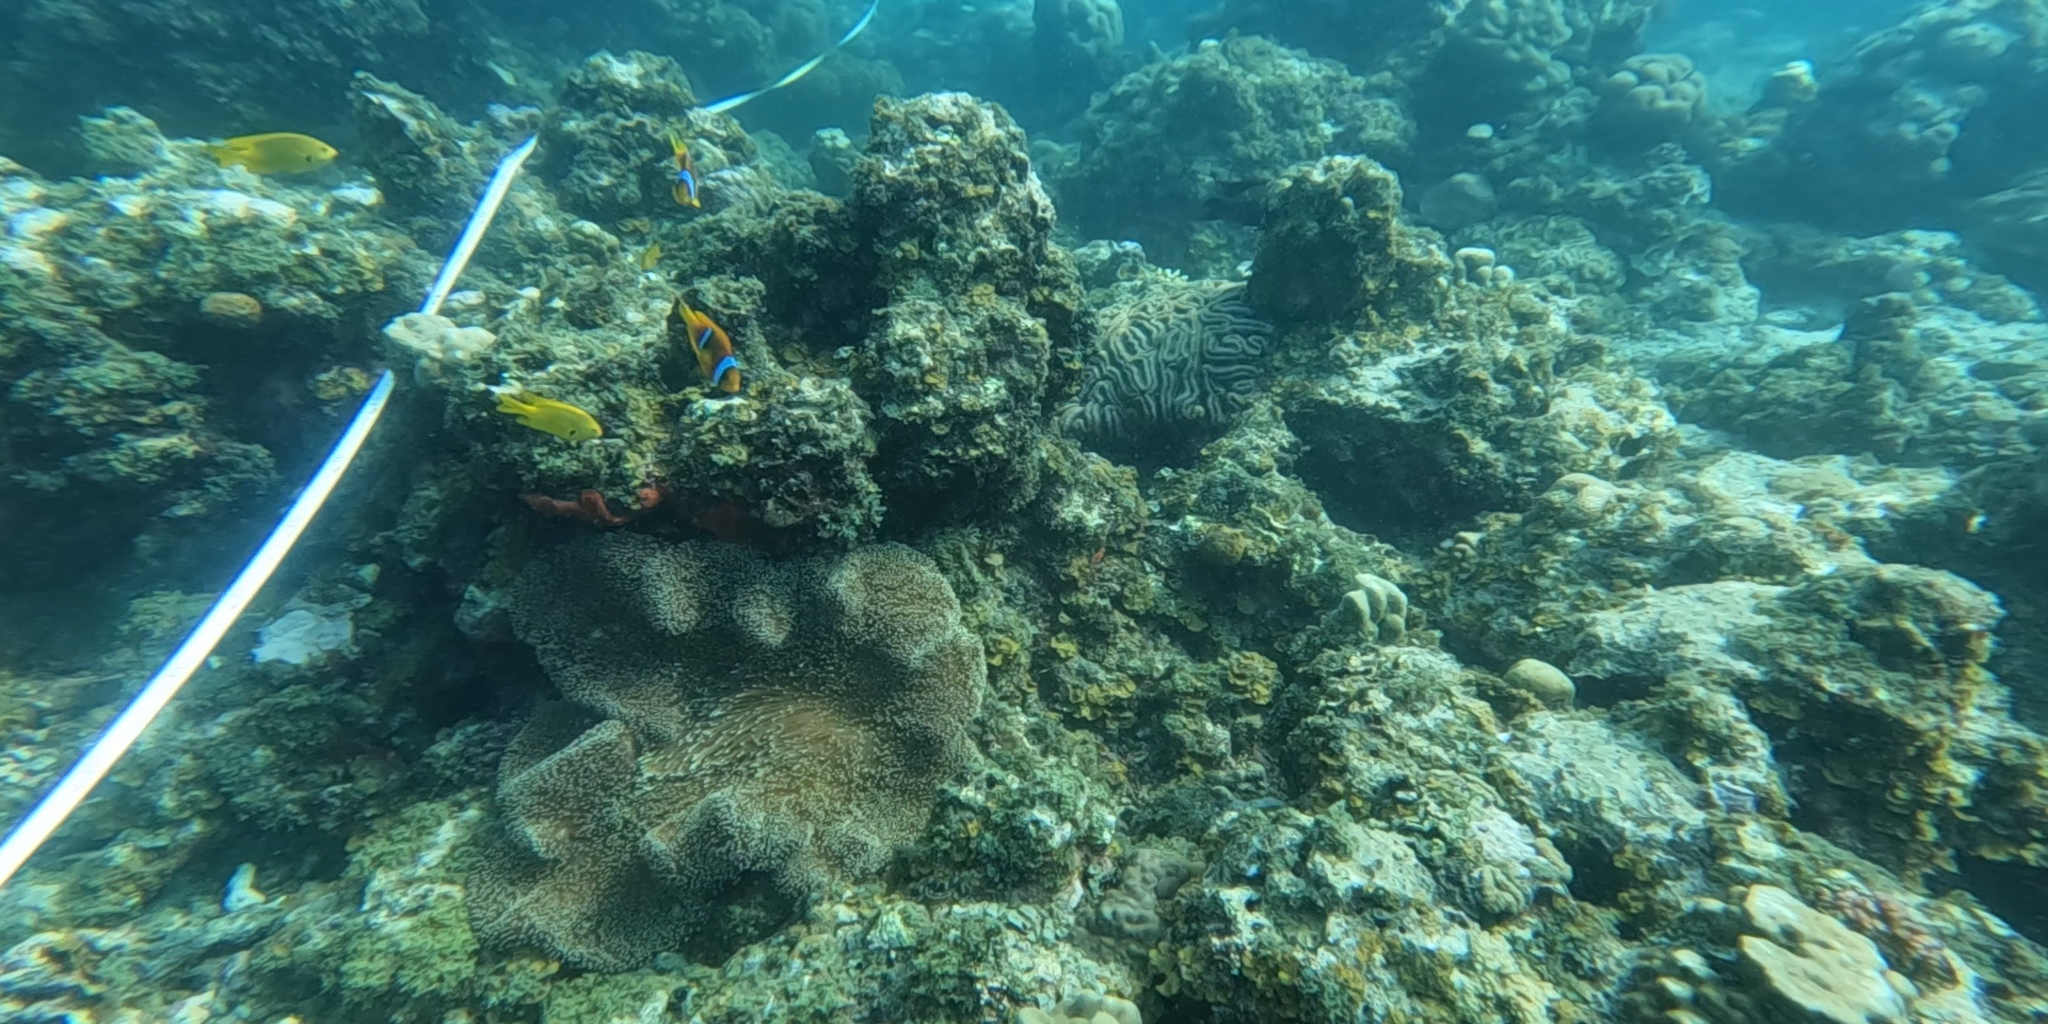

In [4]:

sample = ds['train'][0]
image = sample['image']
mask = sample['label']
display(mask)
print(np.shape(mask))
display(image)

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1517
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 166
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 392
    })
})

In [6]:
from collections import namedtuple

Label = namedtuple('Label', [
    'name',
    'id',
    'trainId',
    'category',
    'categoryId',
    'hasInstances',
    'ignoreInEval',
    'color',
])

# Category mapping (custom, feel free to adjust)
category_map = {
    'coral': 0,
    'animal': 1,
    'substrate': 2,
    'human': 3,
    'object': 4,
    'plant': 5,
    'trash': 6,
    'unknown': 7,
    'void': 8
}

labels = [
    #              name                       id  trainId  category           categoryId  hasInstances  ignoreInEval  color
    Label('unlabeled',                        0,     255,  'void',            category_map['void'],     False,       True,   (255, 255, 255)),
    Label('seagrass',                         1,       0,  'plant',           category_map['plant'],    False,       False,  (125, 222, 125)),
    Label('trash',                            2,       1,  'trash',           category_map['trash'],    False,       False,  (255, 0, 134)),
    Label('other coral dead',                 3,       2,  'coral',           category_map['coral'],    False,       False,  (114, 60, 61)),
    Label('other coral bleached',             4,       3,  'coral',           category_map['coral'],    False,       False,  (250, 224, 225)),
    Label('sand',                             5,       4,  'substrate',       category_map['substrate'],False,       False,  (194, 178, 128)),
    Label('other coral alive',                6,       5,  'coral',           category_map['coral'],    False,       False,  (224, 118, 119)),
    Label('human',                            7,       6,  'human',           category_map['human'],    True,        False,  (255, 0, 0)),
    Label('transect tools',                   8,       7,  'object',          category_map['object'],   False,       False,  (8, 205, 12)),
    Label('fish',                             9,       8,  'animal',          category_map['animal'],   True,        False,  (255, 255, 0)),
    Label('algae covered substrate',         10,       9,  'substrate',       category_map['substrate'],False,       False,  (125, 163, 125)),
    Label('other animal',                    11,      10,  'animal',          category_map['animal'],   False,       False,  (0, 255, 255)),
    Label('unknown hard substrate',          12,      11,  'unknown',         category_map['unknown'],  False,       False,  (125, 125, 125)),
    Label('background',                      13,      255, 'void',            category_map['void'],     False,       True,   (29, 162, 216)),
    Label('dark',                            14,      255, 'void',            category_map['void'],     False,       True,   (31, 31, 31)),
    Label('transect line',                   15,      12,  'object',          category_map['object'],   False,       False,  (0, 255, 0)),
    Label('massive/meandering bleached',     16,      13,  'coral',           category_map['coral'],    False,       False,  (255, 248, 228)),
    Label('massive/meandering alive',        17,      14,  'coral',           category_map['coral'],    False,       False,  (236, 150, 21)),
    Label('rubble',                          18,      15,  'substrate',       category_map['substrate'],False,       False,  (161, 153, 128)),
    Label('branching bleached',             19,      16,  'coral',           category_map['coral'],    False,       False,  (252, 231, 240)),
    Label('branching dead',                 20,      17,  'coral',           category_map['coral'],    False,       False,  (123, 50, 86)),
    Label('millepora',                       21,      18,  'coral',           category_map['coral'],    False,       False,  (244, 150, 115)),
    Label('branching alive',                22,      19,  'coral',           category_map['coral'],    False,       False,  (226, 91, 157)),
    Label('massive/meandering dead',        23,      20,  'coral',           category_map['coral'],    False,       False,  (134, 86, 18)),
    Label('clam',                            24,      21,  'animal',          category_map['animal'],   False,       False,  (189, 255, 234)),
    Label('acropora alive',                  25,      22,  'coral',           category_map['coral'],    False,       False,  (236, 128, 255)),
    Label('sea cucumber',                    26,      23,  'animal',          category_map['animal'],   False,       False,  (0, 231, 255)),
    Label('turbinaria',                      27,      24,  'coral',           category_map['coral'],    False,       False,  (228, 255, 119)),
    Label('table acropora alive',            28,      25,  'coral',           category_map['coral'],    False,       False,  (189, 119, 255)),
    Label('sponge',                          29,      26,  'animal',          category_map['animal'],   False,       False,  (240, 80, 80)),
    Label('anemone',                         30,      27,  'animal',          category_map['animal'],   False,       False,  (0, 255, 189)),
    Label('pocillopora alive',              31,      28,  'coral',           category_map['coral'],    False,       False,  (255, 146, 150)),
    Label('table acropora dead',            32,      29,  'coral',           category_map['coral'],    False,       False,  (85, 53, 116)),
    Label('meandering bleached',            33,      30,  'coral',           category_map['coral'],    False,       False,  (251, 243, 216)),
    Label('stylophora alive',               34,      31,  'coral',           category_map['coral'],    False,       False,  (255, 111, 194)),
    Label('sea urchin',                      35,      32,  'animal',          category_map['animal'],   False,       False,  (0, 142, 255)),
    Label('meandering alive',               36,      33,  'coral',           category_map['coral'],    False,       False,  (230, 193, 0)),
    Label('meandering dead',                37,      34,  'coral',           category_map['coral'],    False,       False,  (119, 100, 14)),
    Label('crown of thorn',                 38,      35,  'animal',          category_map['animal'],   False,       False,  (179, 245, 234)),
    Label('dead clam',                       39,      36,  'animal',          category_map['animal'],   False,       False,  (89, 155, 134)),
]


In [10]:
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])

NUM_CLASSES = 9

# Individual sample transforms (applied during dataset loading)
transform = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [11]:
class Cityscape(Dataset):
    def __init__(self, dcit, transform=transform, label_map='categoryId', operation='train'):
        self.transform = transform
        self.ds = dcit
        self.label_map = label_map
        self.dataset_ops = operation
        self.id_2_train = {}
        self.id_2_cat = {}
        self.trainid_2_name = {}
        self.train_2_id = {}
        self.id_2_name = {}

        self.categoryid_2_name = {}

        for lbl in labels:
            self.id_2_train[lbl.id] = 0 if lbl.ignoreInEval else lbl.trainId
            self.id_2_cat[lbl.id] = lbl.categoryId
            if not lbl.ignoreInEval:
                self.trainid_2_name[lbl.trainId] = lbl.name
                self.train_2_id[lbl.trainId] = lbl.id
            self.id_2_name[lbl.id] = lbl.name

            if lbl.categoryId not in self.categoryid_2_name:
                self.categoryid_2_name[lbl.categoryId] = lbl.category

    def get_category_info(self):
        """Helper method to get category information"""
        return {
            'categoryid_2_name': self.categoryid_2_name,
            'num_categories': len(self.categoryid_2_name),
            'category_ids': list(self.categoryid_2_name.keys())
        }

    def __getitem__(self, idx):
        sample = self.ds[self.dataset_ops][idx]
        img = sample['image']
        mask = np.array(sample['label']).astype(np.float32)

        if self.label_map == 'id':
            mask[mask == -1] = 0
        elif self.label_map == 'trainId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, train_id in self.id_2_train.items():
                mapped_mask[mask == _id] = train_id
            mask = mapped_mask
        elif self.label_map == 'categoryId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, cat_id in self.id_2_cat.items():
                mapped_mask[mask == _id] = cat_id
            mask = mapped_mask

        mask = Image.fromarray(mask)
        mask = mask.resize((256, 256), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()

        if self.transform:
            img = self.transform(img)

        return img, mask

    def __len__(self):
        return len(self.ds[self.dataset_ops])

In [12]:
dataset = Cityscape(ds,  transform=transform,operation='train',label_map='categoryId')
category_info = dataset.get_category_info()
print("Category Info:", category_info)


Category Info: {'categoryid_2_name': {8: 'void', 5: 'plant', 6: 'trash', 0: 'coral', 2: 'substrate', 3: 'human', 4: 'object', 1: 'animal', 7: 'unknown'}, 'num_categories': 9, 'category_ids': [8, 5, 6, 0, 2, 3, 4, 1, 7]}


In [13]:
import os
print(os.cpu_count())

32


In [14]:


dataset = Cityscape(ds, transform=transform, operation='train')
data_loader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True, 
    num_workers=16   
)

# # Batch-level transforms (applied after loading batches)
# cutmix = v2.CutMix(num_classes=NUM_CLASSES)
# mixup = v2.MixUp(num_classes=NUM_CLASSES)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


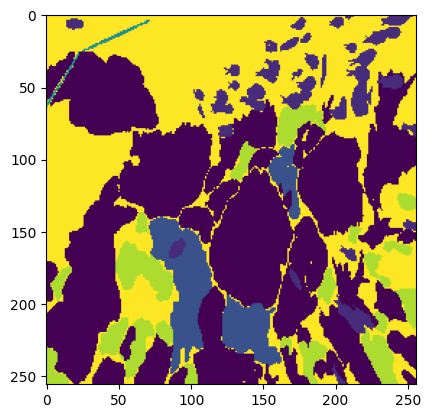

In [15]:
img,label = next(iter(data_loader))
img_np = img[0].cpu().numpy()
print(np.shape(img))
img_np = img[3].cpu().numpy()
print(np.shape(label))
img_np = img[0].cpu().numpy()
np.shape(label[1])
label_np = label[1].cpu().numpy()
plt.imshow(label_np)
img_np = np.transpose(img_np, (1, 2, 0))



In [18]:
dir_path = "/media/adminnio/Volume/Data/Datasets/Corals/models/Unet_Aug_400/weights"
model_name = "Unet_epochs_400" # A descriptive name for your model
model_save_dir = os.path.join(dir_path, model_name)
os.makedirs(model_save_dir, exist_ok=True) # Create the directory if it doesn't exist
log_file_path = os.path.join(model_save_dir, f"{model_name}_training_log.csv")
log_data = []  
best_iou = -1.0 


In [19]:
import segmentation_models_pytorch as smp
from torchinfo import summary
model = smp.Unet(
    encoder_name="resnet50",         
    encoder_weights="imagenet",      
    in_channels=3,                   
    classes=9                        
)
model.to(device)
summary(model, input_size=(1, 3, 256, 256)) 


Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 9, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                        [1, 512, 32, 32]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 32, 32]          379,392

In [20]:
import wandb
val_dataset = Cityscape(ds,  transform=transform,operation='validation')
val_data_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True)
train_metrics = {

    'seg_loss' : [],
    'loss': [],
    'IOU' : []

}
eval_metrics = {
    'loss': [],
    'iou': [],
    'iou_class_mean': [],
    'iou_per_class_all': []
}
num_classes = 9
jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, average=None)

def evaluate_metrics(pred,mask,num_classes):
    preds_net = torch.argmax(pred, dim=1) #[B, C, H, W]  →  [B, H, W]
    per_class_iou = jaccard(preds_net.detach().cpu(), mask.detach().cpu())  # [num_classes] return IOU per class
    mean_iou = per_class_iou.mean().item()
    # eval_metrics['IOU'].append(mean_iou)
    # eval_metrics['IOU_class_mean'].append(mean_iou)
    # eval_metrics['IOU_per_class_all'].append(per_class_iou.tolist())
    # for c in range(num_classes):
            # eval_metrics[f"IOU_class_{c}"].append(per_class_iou[c].item())
    return mean_iou, per_class_iou


In [21]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Currently logged in as: jasjap (jasjappan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Setup device and directories
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'Unet_withAug_400'
model_save_dir = './checkpoints'
log_file_path = './training_log.csv'
os.makedirs(model_save_dir, exist_ok=True)

# Hyperparameters and constants
num_classes = 9
epochs = 400
learning_rate = 1e-5

# Metric
jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, average=None)

# Define your metric evaluation function
def evaluate_metrics(pred, mask, num_classes):
    preds_net = torch.argmax(pred, dim=1)  # [B, C, H, W] → [B, H, W]
    per_class_iou = jaccard(preds_net.detach().cpu(), mask.detach().cpu())  # [num_classes] IOU per class
    mean_iou = per_class_iou.mean().item()
    return mean_iou, per_class_iou

# Initialize model
torch.cuda.empty_cache()
# model = deeplabv3_resnet50(pretrained=True)
# model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = OneCycleLR(optimizer, 
                       max_lr=5.0e-4,                     
                       steps_per_epoch=len(data_loader),  
                       epochs=epochs,                      
                       anneal_strategy='cos')              

# DataLoaders (assumed defined)
# data_loader = ...
# val_data_loader = ...

best_iou = 0.0
log_data = []
wandb.init(
    project="CoralSegmentaton",
    name=model_name,
    config={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "num_classes": num_classes,
        "model": "Unet-resnet50"
    }
)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    total_batches = len(data_loader)

    train_metrics = {'loss': [], 'iou': []}
    val_metrics = {'loss': [], 'iou': [], 'iou_class_mean': [], 'iou_per_class_all': []}

    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 30)

    progress_bar = tqdm(enumerate(data_loader), total=total_batches, leave=False)
    for batch_idx, (images, masks) in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # loss = criterion(outputs['out'], masks)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        batch_iou, per_class_iou = evaluate_metrics(outputs, masks, num_classes)
        # batch_iou, per_class_iou = evaluate_metrics(outputs['out'], masks, num_classes)
        running_iou += batch_iou

        train_metrics['loss'].append(loss.item())
        train_metrics['iou'].append(batch_iou)

        avg_loss = running_loss / (batch_idx + 1)
        avg_iou = running_iou / (batch_idx + 1)

        progress_bar.set_description(f"Batch {batch_idx+1}/{total_batches}")
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}", iou=f"{avg_iou:.4f}")

    epoch_loss = running_loss / total_batches
    epoch_iou = running_iou / total_batches
    print(f"Epoch {epoch+1} finished. Average Loss: {epoch_loss:.4f}, Average IoU: {epoch_iou:.4f}")

    # Validation phase
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="validation"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # loss = criterion(outputs['out'], labels)
            loss = criterion(outputs, labels)
            val_metrics['loss'].append(loss.item())
            mean_iou, per_class_iou = evaluate_metrics(outputs, labels, num_classes)
            # mean_iou, per_class_iou = evaluate_metrics(outputs['out'], labels, num_classes)
            val_metrics['iou'].append(mean_iou)
            val_metrics['iou_class_mean'].append(mean_iou)
            val_metrics['iou_per_class_all'].append(per_class_iou.tolist())

    val_loss_avg = sum(val_metrics['loss']) / len(val_metrics['loss'])
    val_iou_avg = sum(val_metrics['iou']) / len(val_metrics['iou'])

    print(f"Validation Avg Loss: {val_loss_avg:.4f}, Avg IoU: {val_iou_avg:.4f}")

    # Log metrics
    log_data.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_iou': epoch_iou,
        'val_loss': val_loss_avg,
        'val_iou': val_iou_avg
    })
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": epoch_loss,
        "train/iou": epoch_iou,
        "validate/loss": val_loss_avg,
        "validate/iou": val_iou_avg
})
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(model_save_dir, f"{model_name}_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'iou': epoch_iou,
            'best_iou': best_iou,
            'log_data': log_data,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    # Save best model with complete state
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_model_path = os.path.join(model_save_dir, f"{model_name}_best_iou.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'iou': epoch_iou,
            'best_iou': best_iou,
            'log_data': log_data,
        }, best_model_path)
    print(f"New best model saved to {best_model_path} with IoU: {best_iou:.4f}")

    # Save training log
    pd.DataFrame(log_data).to_csv(log_file_path, index=False)
    print(f"Training log updated at {log_file_path}")

print("\nTraining complete!")


wandb: Currently logged in as: jasjap (jasjappan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/400
------------------------------


Epoch 1 finished. Average Loss: 1.9045, Average IoU: 0.0853


validation: 100%|███████████████████████████████| 20/20 [00:09<00:00,  2.22it/s]


Validation Avg Loss: 1.7311, Avg IoU: 0.1015
New best model saved to ./checkpoints/Unet_withAug_400_best_iou.pth with IoU: 0.0853
Training log updated at ./training_log.csv

Epoch 2/400
------------------------------


Batch 106/189:  56%|▌| 106/189 [00:14<00:07, 11.30it/s, iou=0.1124, loss=1.6596]

In [68]:

def load_model_for_inference(checkpoint_path, num_classes=9, device='cuda'):
    """
    Load the trained model for inference
    
    Args:
        checkpoint_path: Path to the saved checkpoint (.pth file)
        num_classes: Number of classes (should match training)
        device: Device to load model on ('cuda' or 'cpu')
    
    Returns:
        model: Loaded model ready for inference
    """
    model = smp.Unet(
        encoder_name="resnet50",         
        encoder_weights="imagenet",      
        in_channels=3,                   
        classes=9                        
    )
    model.to(device)
    summary(model, input_size=(1, 3, 256, 256)) 

    
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load the model state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()
    
    print(f"Model loaded successfully!")
    print(f"Best IoU from training: {checkpoint.get('best_iou', 'N/A'):.4f}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
    
    return model 

ckpt_path = "./checkpoints/deeplabv3_cityscape_best_iou.pth"
load_model_for_inference(ckpt_path)

Model loaded successfully!
Best IoU from training: 0.6992
Epoch: 195


/tmp/ipykernel_596598/3180848067.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [71]:
 

# # Set up model for evaluation
# model.to(device)
# model.eval()
# criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

# def compute_iou(pred, target, num_classes=9, ignore_index=255):
#     """
#     pred: (N, H, W) predicted labels
#     target: (N, H, W) ground truth labels
#     Returns: IoU for each class, ignoring ignore_index
#     """
#     ious = []
#     pred = pred.view(-1)
#     target = target.view(-1)
    
#     for cls in range(num_classes):
#         if cls == ignore_index:
#             continue
#         pred_inds = pred == cls
#         target_inds = target == cls
#         intersection = (pred_inds & target_inds).sum().item()
#         union = (pred_inds | target_inds).sum().item()
#         if union == 0:
#             ious.append(float('nan'))  # no ground truth for this class in batch
#         else:
#             ious.append(intersection / union)
#     return ious

# def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
#     """
#     Denormalize image tensor for visualization
#     """
#     tensor = tensor.clone()
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)
#     return torch.clamp(tensor, 0, 1)

# def plot_predictions_with_gt(model, data_loader, device, num_samples=10, num_classes=9):
#     """
#     Plot original images with ground truth and predicted masks
#     """
#     # Use global colors array and create colormap
#     # Add extra colors if needed
#     global_colors = colors.copy()
#     if len(global_colors) < num_classes:
#         extra_colors = plt.cm.tab10(np.linspace(0, 1, num_classes - len(global_colors)))
#         global_colors = np.vstack([global_colors, extra_colors])
#     cmap = ListedColormap(global_colors[:num_classes])
    
#     # Collect samples from multiple batches if needed
#     all_images = []
#     all_labels = []
#     all_preds = []
#     all_ious = []
    
#     model.eval()
#     samples_collected = 0
    
#     with torch.no_grad():
#         for images, labels in data_loader:
#             if samples_collected >= num_samples:
#                 break
                
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             preds = torch.argmax(outputs, dim=1)
            
#             # Calculate IoU for each sample in the batch
#             batch_size = images.shape[0]
#             for i in range(batch_size):
#                 if samples_collected >= num_samples:
#                     break
                    
#                 # Get single sample
#                 single_pred = preds[i:i+1]
#                 single_label = labels[i:i+1]
#                 single_image = images[i:i+1]
                
#                 # Calculate IoU for this sample
#                 sample_ious = compute_iou(single_pred, single_label, num_classes)
#                 sample_miou = np.nanmean(sample_ious)
                
#                 # Store data
#                 all_images.append(single_image.cpu())
#                 all_labels.append(single_label.cpu())
#                 all_preds.append(single_pred.cpu())
#                 all_ious.append(sample_miou)
                
#                 samples_collected += 1
    
#     # Create visualization
#     fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
#     if num_samples == 1:
#         axes = axes.reshape(1, -1)
    
#     for idx in range(num_samples):
#         # Get data for this sample
#         img_tensor = all_images[idx][0]  # Remove batch dimension
#         gt_mask = all_labels[idx][0].numpy()
#         pred_mask = all_preds[idx][0].numpy()
#         sample_iou = all_ious[idx]
        
#         # Denormalize image for display
#         img_display = denormalize_image(img_tensor).numpy().transpose(1, 2, 0)
#         img_display = np.clip(img_display, 0, 1)
        
#         # Plot original image
#         axes[idx, 0].imshow(img_display)
#         axes[idx, 0].set_title(f'Original Image {idx+1}')
#         axes[idx, 0].axis('off')
        
#         # Plot ground truth mask
#         axes[idx, 1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
#         axes[idx, 1].set_title(f'Ground Truth {idx+1}')
#         axes[idx, 1].axis('off')
        
#         # Plot predicted mask
#         im = axes[idx, 2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
#         axes[idx, 2].set_title(f'Prediction {idx+1}\nIoU: {sample_iou:.3f}')
#         axes[idx, 2].axis('off')
    
#     # Add colorbar
#     cbar = plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
#     cbar.set_label('Class Labels')
#     cbar.set_ticks(range(num_classes))
#     cbar.set_ticklabels([f'Class {i}' for i in range(num_classes)])
    
#     plt.tight_layout()
#     plt.show()

# # Define colors for visualization (moved outside function for reuse)
# colors = [
#     [114, 60, 61],     # coral      → **Dark Reddish Brown / Rosewood**
#     [255, 255, 0],     # animal     → **Bright Yellow**
#     [194, 178, 128],   # substrate  → **Tan / Khaki**
#     [255, 0, 0],       # human      → **Bright Red**
#     [8, 205, 12],      # object     → **Lime Green**
#     [125, 222, 125],   # plant      → **Light Green / Pale Green**
#     [255, 0, 134],     # trash      → **Hot Pink / Deep Pink**
#     [125, 125, 125],   # unknown    → **Medium Gray**
#     [255, 255, 255],   # void       → **White**
# ]


# colors = np.array(colors) / 255.0  # Normalize to [0,1] range

# # Evaluation loop with metrics collection
# losses = []
# miou_list = []
# class_ious = {f'class_{i}': [] for i in range(9)}  # Assuming 9 classes

# print("Starting evaluation...")
# with torch.no_grad():
#     for images, labels in tqdm(data_loader, desc="Evaluating"):
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
        
#         # Calculate loss
#         loss = criterion(outputs, labels)
#         losses.append(loss.item())
        
#         # Calculate IoU
#         preds = torch.argmax(outputs, dim=1)
#         ious = compute_iou(preds, labels, num_classes=9)
        
#         # Store per-class IoUs
#         for i, iou in enumerate(ious):
#             if not np.isnan(iou):
#                 class_ious[f'class_{i}'].append(iou)
        
#         # Calculate mean IoU (ignoring NaNs)
#         miou = np.nanmean(ious)
#         if not np.isnan(miou):
#             miou_list.append(miou)

# # Print final metrics
# mean_loss = np.mean(losses)
# mean_miou = np.mean(miou_list) if miou_list else 0.0

# print(f"\n=== EVALUATION RESULTS ===")
# print(f"Final Mean Loss: {mean_loss:.4f}")
# print(f"Final Mean IoU: {mean_miou:.4f}")

# # Print per-class IoU
# print(f"\n=== PER-CLASS IoU ===")
# for i in range(9):
#     class_iou_values = class_ious[f'class_{i}']
#     if class_iou_values:
#         class_mean_iou = np.mean(class_iou_values)
#         class_std_iou = np.std(class_iou_values)
#         print(f"Class {i}: {class_mean_iou:.4f} ± {class_std_iou:.4f} (n={len(class_iou_values)})")
#     else:
#         print(f"Class {i}: No valid samples")

# # Plot metrics
# plt.figure(figsize=(15, 5))

# # Loss plot
# plt.subplot(1, 3, 1)
# plt.plot(losses, label='Loss', color='red', alpha=0.7)
# plt.xlabel('Batch')
# plt.ylabel('Loss')
# plt.title('Loss over Batches')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # mIoU plot
# plt.subplot(1, 3, 2)
# plt.plot(miou_list, label='mIoU', color='green', alpha=0.7)
# plt.xlabel('Batch')
# plt.ylabel('mIoU')
# plt.title('Mean IoU over Batches')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Per-class IoU bar plot
# plt.subplot(1, 3, 3)
# class_means = []
# class_names = []
# for i in range(9):
#     if class_ious[f'class_{i}']:
#         class_means.append(np.mean(class_ious[f'class_{i}']))
#         class_names.append(f'C{i}')

# if class_means:
#     bars = plt.bar(class_names, class_means, alpha=0.7, color=colors[:len(class_means)])
#     plt.xlabel('Class')
#     plt.ylabel('Mean IoU')
#     plt.title('Per-Class Mean IoU')
#     plt.xticks(rotation=45)
#     plt.grid(True, alpha=0.3)
#     # Add value labels on bars
#     for bar, value in zip(bars, class_means):
#         plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
#                 f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# plt.tight_layout()
# plt.show()

# # Plot sample predictions with ground truth
# print("\nGenerating sample predictions visualization...")
# plot_predictions_with_gt(model, data_loader, device, num_samples=10, num_classes=9)

# print("\nEvaluation complete!")

🚀 Starting visualization with improved layout...
📊 Plotting metrics...
Debug: Checking eval_metrics1 lengths:
  seg_loss: 0
  loss: 5
  IOU: 5
  IOU_class_mean: 0
  IOU_per_class_all: 0
  IOU_class_0: 5
  IOU_class_1: 5
  IOU_class_2: 5
  IOU_class_3: 5
  IOU_class_4: 5
  IOU_class_5: 5
  IOU_class_6: 5
  IOU_class_7: 5
  IOU_class_8: 5


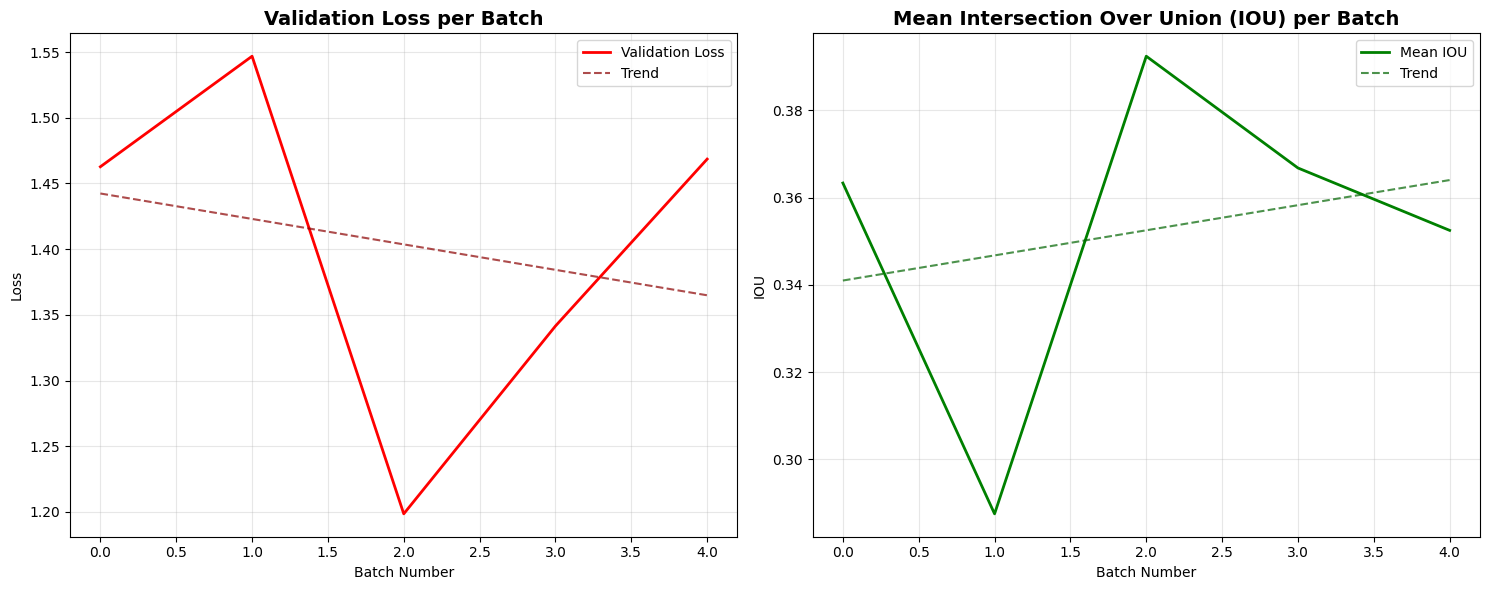

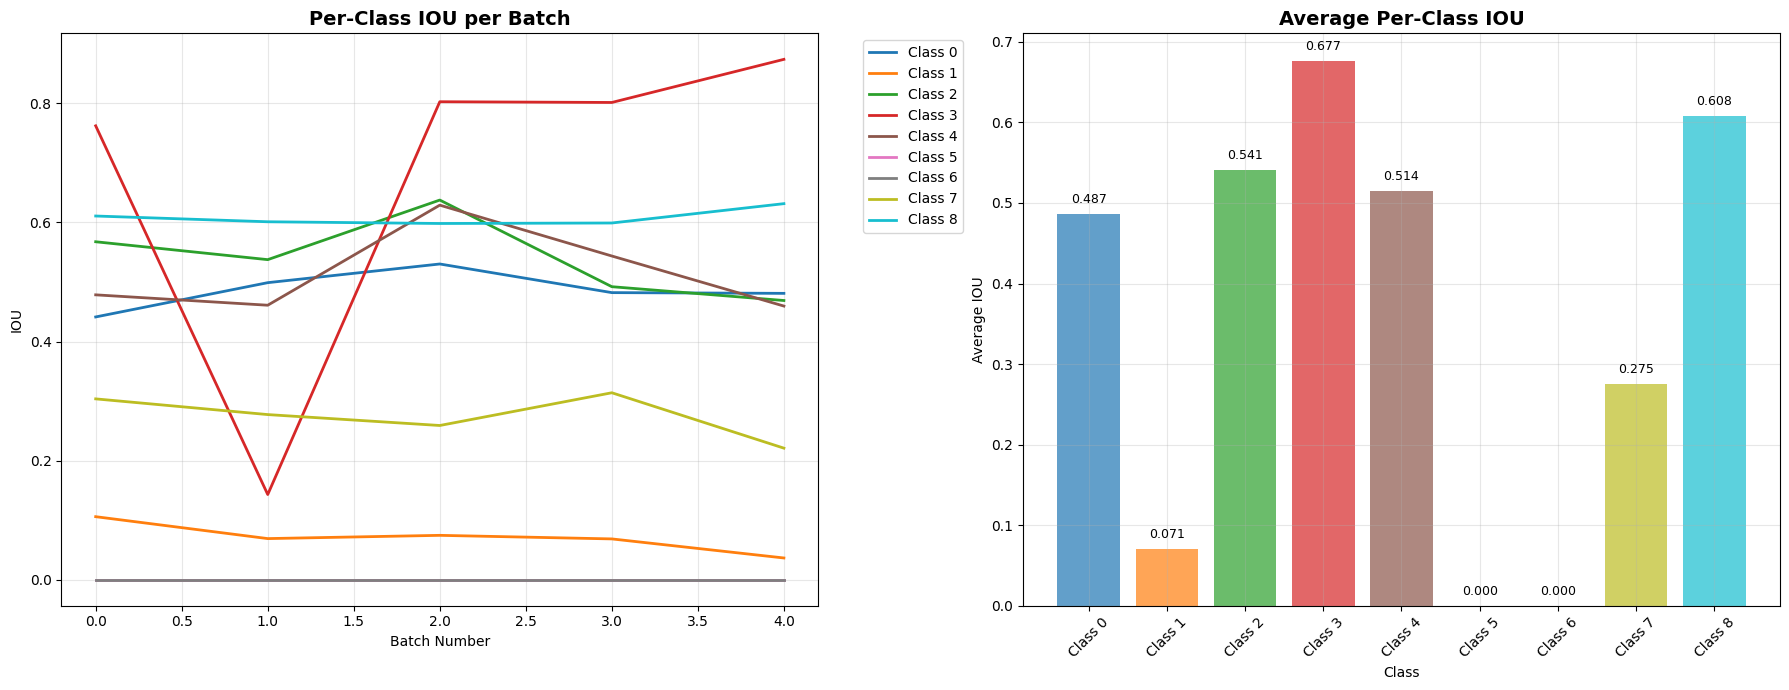

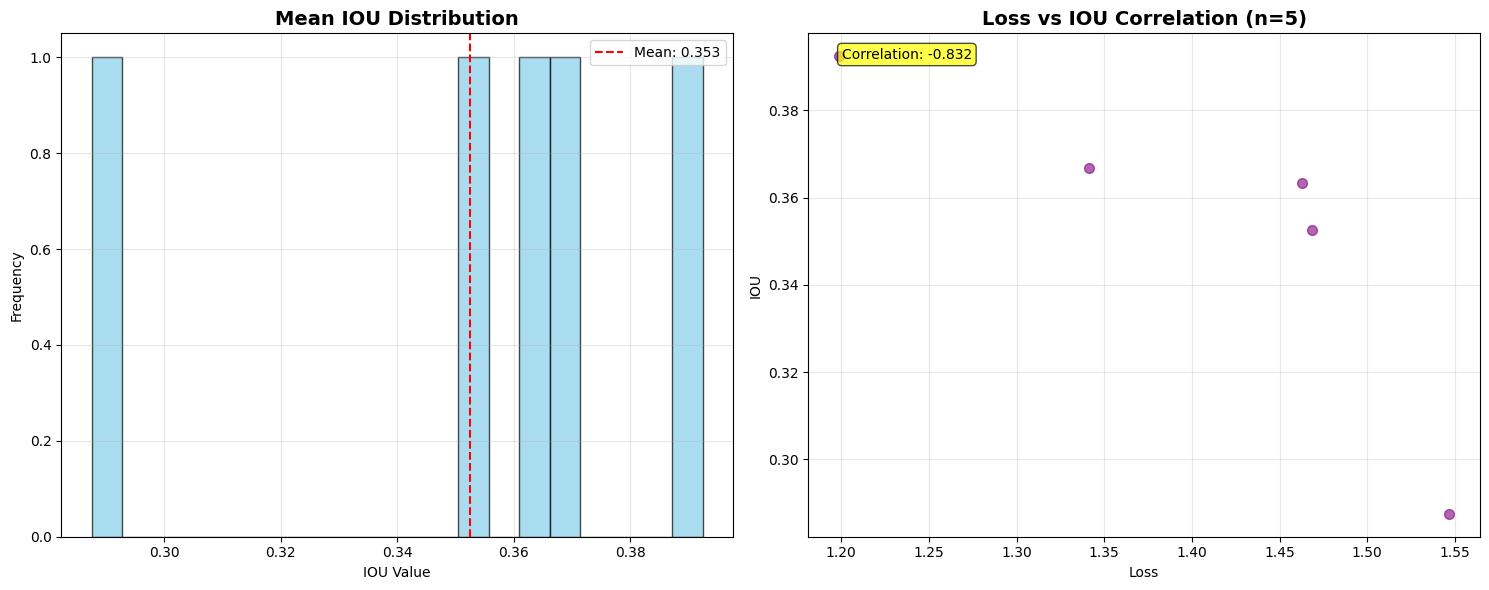


EVALUATION SUMMARY STATISTICS
📊 LOSS METRICS:
   Average Loss: 1.4036 ± 0.1218
   Best Loss: 1.1985
   Worst Loss: 1.5469

🎯 IOU METRICS:
   Average Mean IOU: 0.3525 ± 0.0350
   Best Mean IOU: 0.3924
   Worst Mean IOU: 0.2875

🏷️  PER-CLASS AVERAGE IOUs:
   Class 0: 0.4867 ± 0.0289
   Class 1: 0.0708 ± 0.0220
   Class 2: 0.5408 ± 0.0594
   Class 3: 0.6768 ± 0.2693
   Class 4: 0.5144 ± 0.0651
   Class 5: 0.0000 ± 0.0000
   Class 6: 0.0000 ± 0.0000
   Class 7: 0.2750 ± 0.0333
   Class 8: 0.6082 ± 0.0125
🖼️  Plotting predictions...
Generating prediction visualizations...


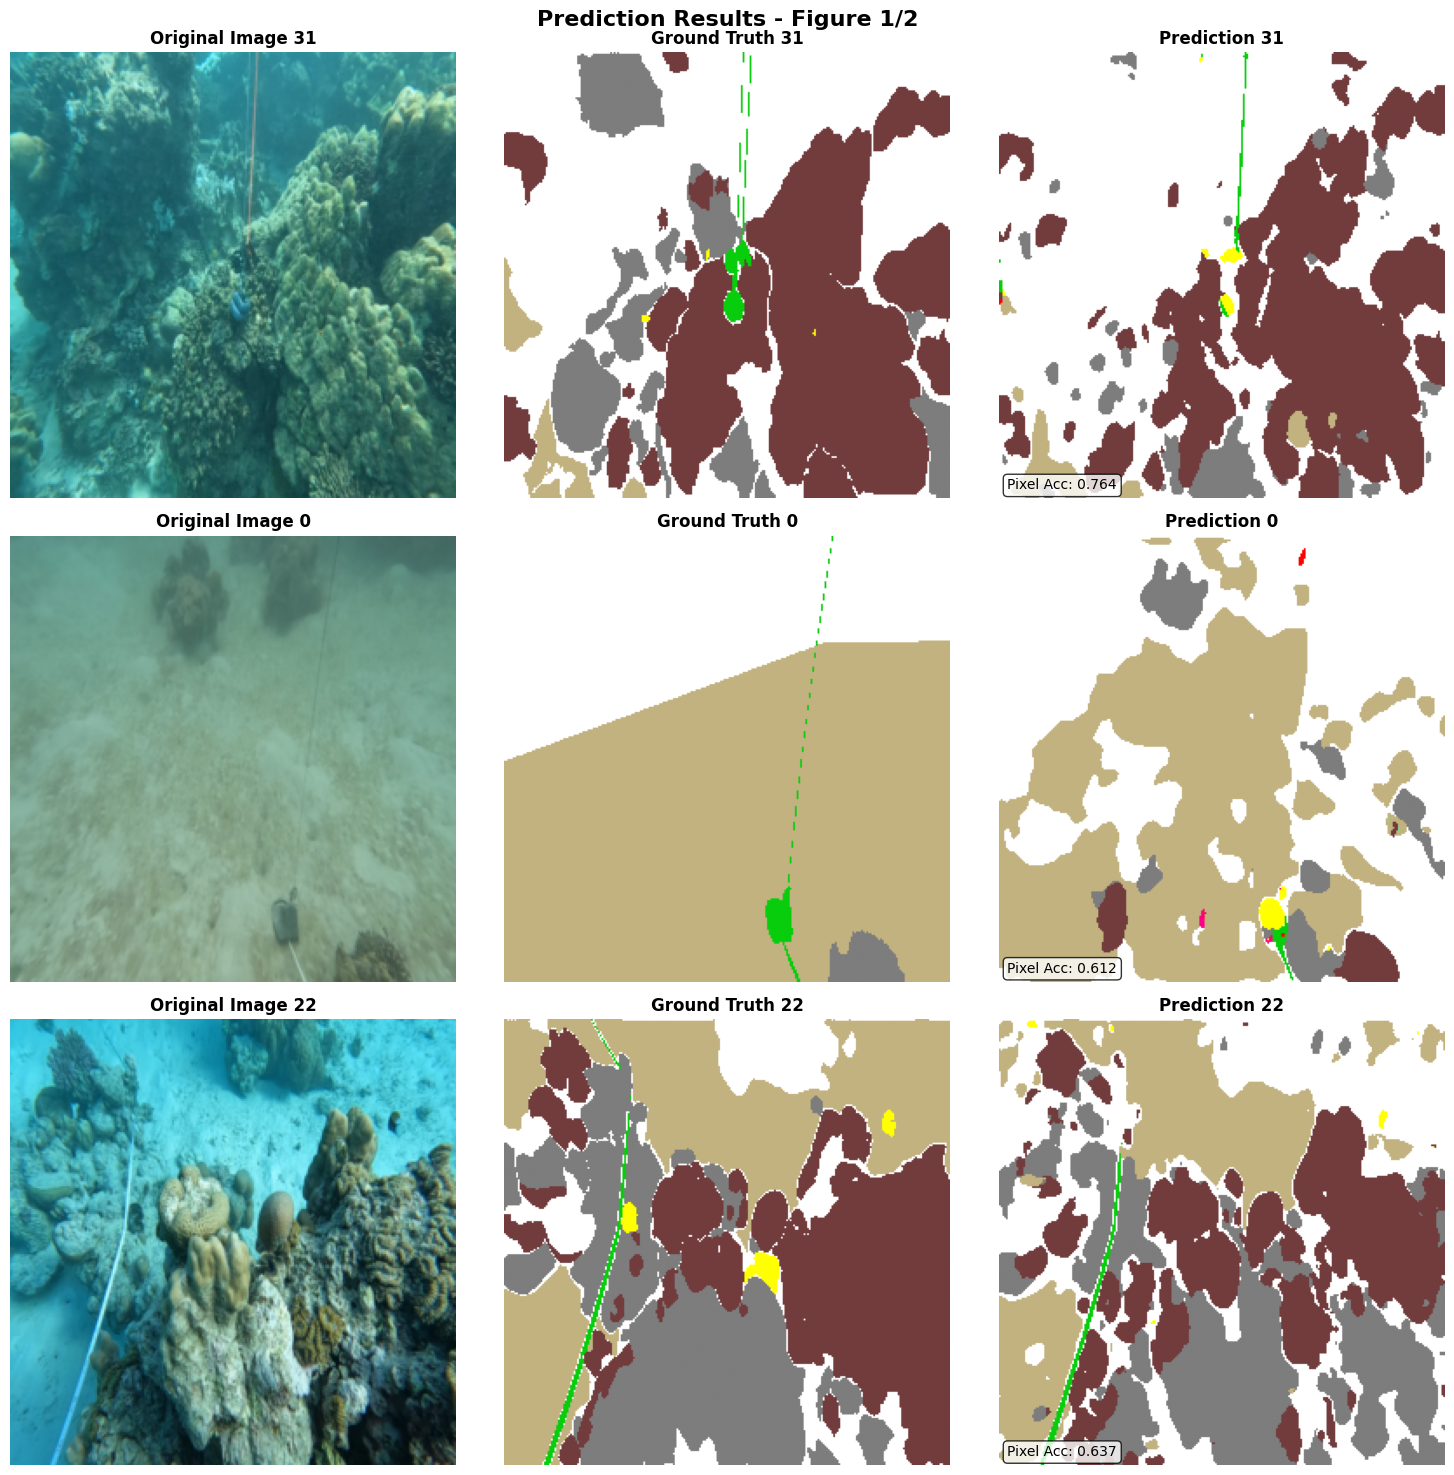

/tmp/ipykernel_596598/1516519438.py:322: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


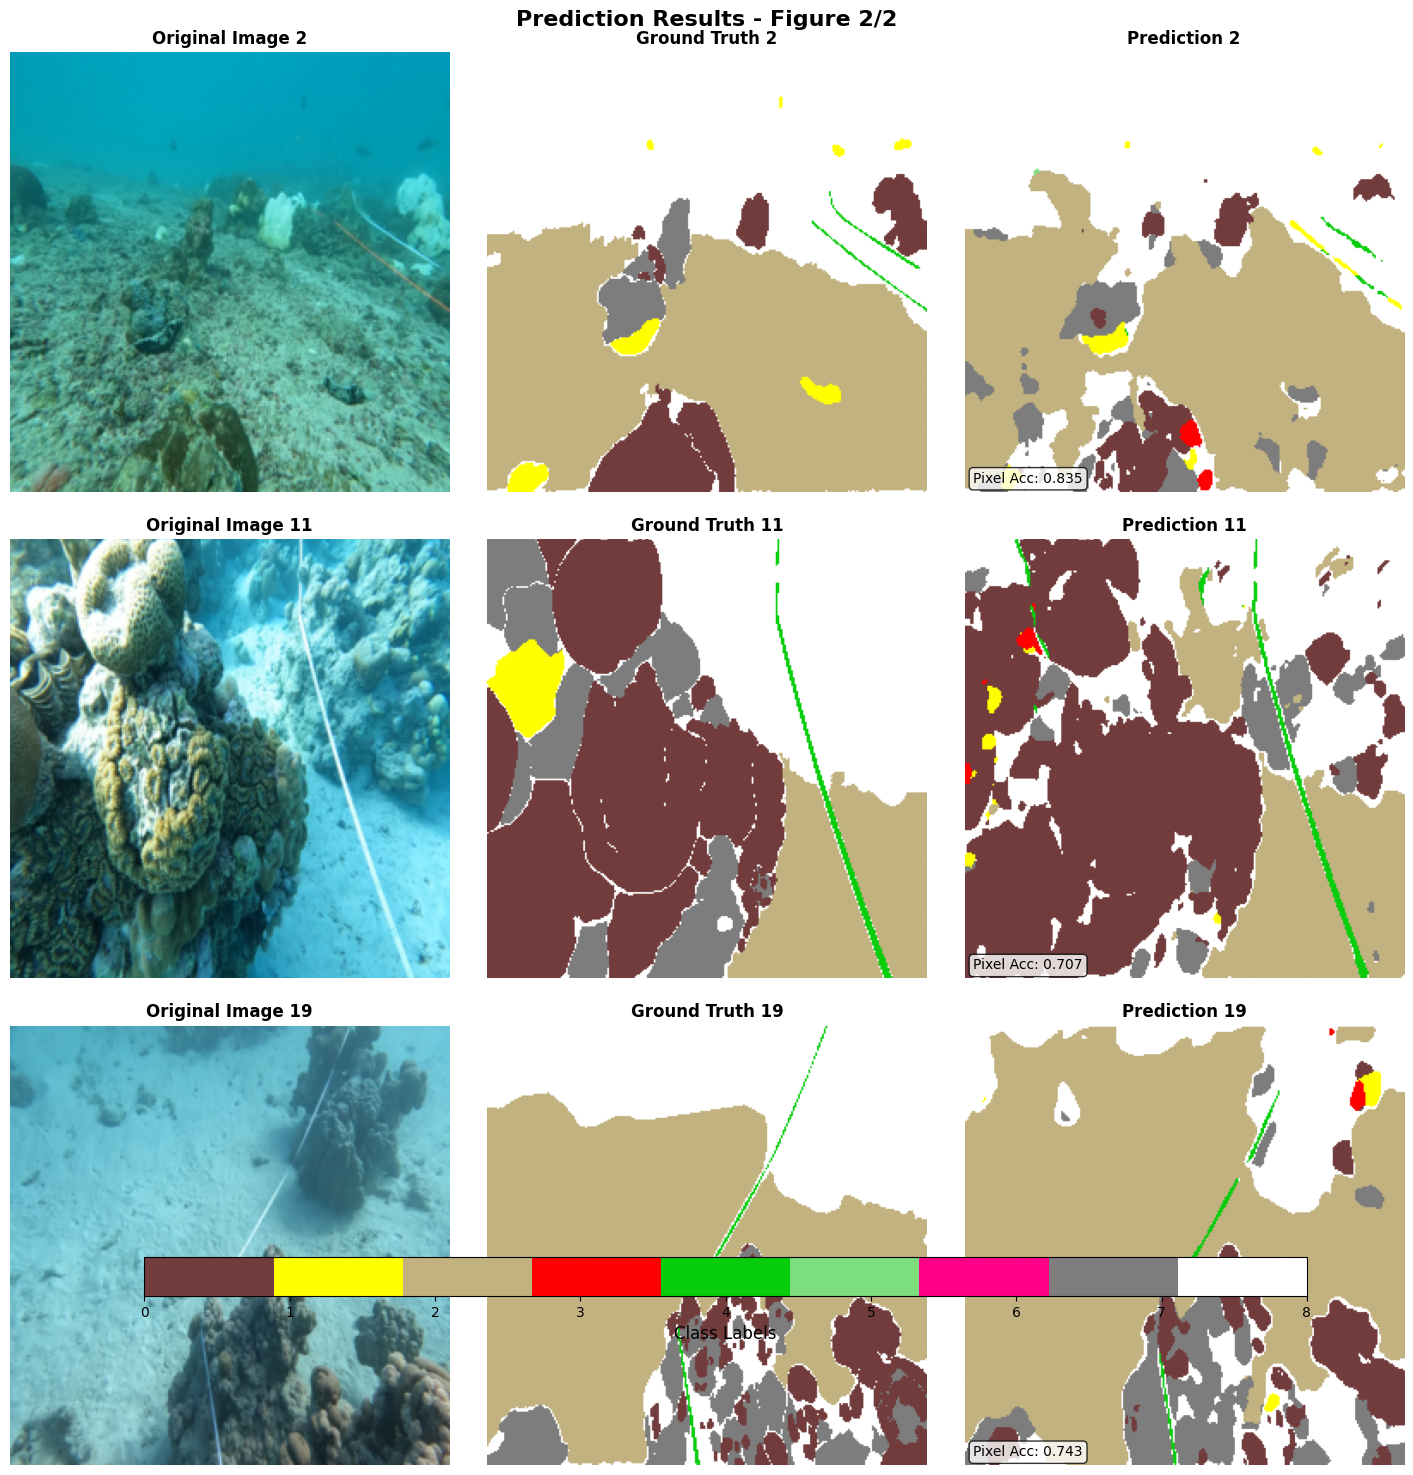

📈 Analyzing class performance...
Generating class performance analysis...


/tmp/ipykernel_596598/1516519438.py:353: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(class_ious_data, labels=class_names, patch_artist=True)


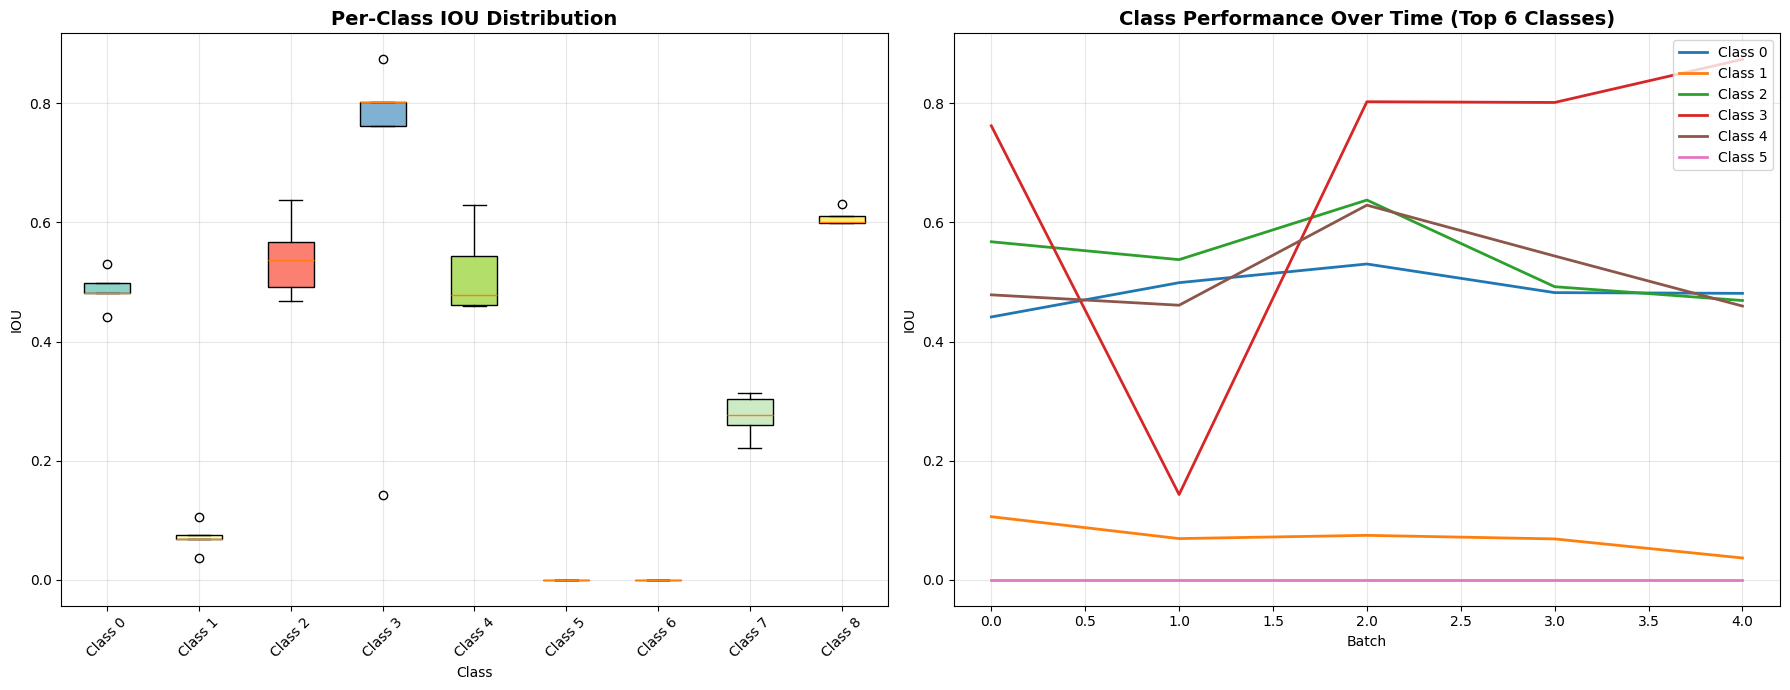

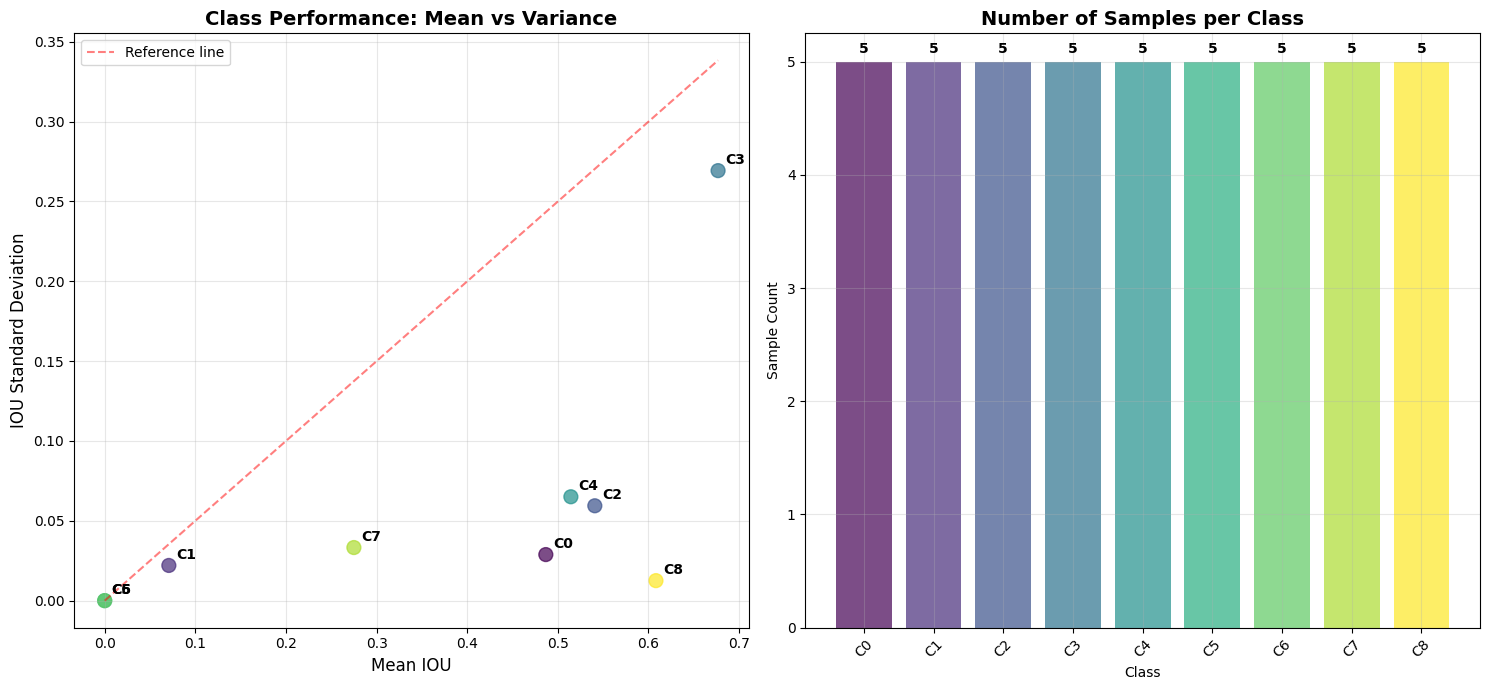

In [72]:


# Set matplotlib parameters for better visibility
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# 1. METRICS PLOTTING - Split into separate plots for better visibility
def plot_metrics_visible(eval_metrics1):
    """Plot all evaluation metrics in separate figures for better visibility"""
    
    # Debug: Print lengths to identify the issue
    print("Debug: Checking eval_metrics1 lengths:")
    for key, value in eval_metrics1.items():
        if isinstance(value, list):
            print(f"  {key}: {len(value)}")
    
    # Check if we have any data
    if not eval_metrics1['loss'] and not eval_metrics1['IOU']:
        print("ERROR: No evaluation data found! Make sure to run evaluate_model() first.")
        return
    
    # PLOT 1: Loss and IoU trends
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Loss
    if eval_metrics1['loss']:
        ax1.plot(eval_metrics1['loss'], label='Validation Loss', color='red', linewidth=2)
        ax1.set_title('Validation Loss per Batch', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add trend line
        if len(eval_metrics1['loss']) > 1:
            z = np.polyfit(range(len(eval_metrics1['loss'])), eval_metrics1['loss'], 1)
            p = np.poly1d(z)
            ax1.plot(range(len(eval_metrics1['loss'])), p(range(len(eval_metrics1['loss']))), 
                    "--", alpha=0.7, color='darkred', label='Trend')
            ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'No loss data available', ha='center', va='center', fontsize=12)
        ax1.set_title('Validation Loss per Batch')
    
    # Mean IOU
    if eval_metrics1['IOU']:
        ax2.plot(eval_metrics1['IOU'], label='Mean IOU', color='green', linewidth=2)
        ax2.set_title('Mean Intersection Over Union (IOU) per Batch', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Batch Number')
        ax2.set_ylabel('IOU')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add trend line
        if len(eval_metrics1['IOU']) > 1:
            z = np.polyfit(range(len(eval_metrics1['IOU'])), eval_metrics1['IOU'], 1)
            p = np.poly1d(z)
            ax2.plot(range(len(eval_metrics1['IOU'])), p(range(len(eval_metrics1['IOU']))), 
                    "--", alpha=0.7, color='darkgreen', label='Trend')
            ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No IOU data available', ha='center', va='center', fontsize=12)
        ax2.set_title('Mean Intersection Over Union (IOU) per Batch')
    
    plt.tight_layout()
    plt.show()
    
    # PLOT 2: Per-Class IOU Analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Per-Class IOU trends
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
    plotted_classes = 0
    avg_class_ious = []
    class_labels = []
    
    for c in range(num_classes):
        if f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"]:
            values = eval_metrics1[f"IOU_class_{c}"]
            ax1.plot(values, label=f'Class {c}', color=colors[c], linewidth=2)
            plotted_classes += 1
            
            # Calculate average for bar plot
            avg_iou = np.mean(values)
            avg_class_ious.append(avg_iou)
            class_labels.append(f'Class {c}')
    
    if plotted_classes > 0:
        ax1.set_title('Per-Class IOU per Batch', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('IOU')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No per-class IOU data available', ha='center', va='center', fontsize=12)
        ax1.set_title('Per-Class IOU per Batch')
    
    # Average Per-Class IOU (Bar plot)
    if avg_class_ious:
        bars = ax2.bar(class_labels, avg_class_ious, color=colors[:len(avg_class_ious)], alpha=0.7)
        ax2.set_title('Average Per-Class IOU', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Class')
        ax2.set_ylabel('Average IOU')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, avg_class_ious):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'No class IOU data available', ha='center', va='center', fontsize=12)
        ax2.set_title('Average Per-Class IOU')
    
    plt.tight_layout()
    plt.show()
    
    # PLOT 3: Distribution Analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # IOU Distribution (Histogram)
    if eval_metrics1['IOU']:
        ax1.hist(eval_metrics1['IOU'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.axvline(np.mean(eval_metrics1['IOU']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(eval_metrics1["IOU"]):.3f}')
        ax1.set_title('Mean IOU Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('IOU Value')
        ax1.set_ylabel('Frequency')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No IOU data for histogram', ha='center', va='center', fontsize=12)
        ax1.set_title('Mean IOU Distribution')
    
    # Loss vs IOU Scatter
    if eval_metrics1['loss'] and eval_metrics1['IOU']:
        min_len = min(len(eval_metrics1['loss']), len(eval_metrics1['IOU']))
        loss_data = eval_metrics1['loss'][:min_len]
        iou_data = eval_metrics1['IOU'][:min_len]
        
        if min_len > 0:
            scatter = ax2.scatter(loss_data, iou_data, alpha=0.6, color='purple', s=50)
            ax2.set_title(f'Loss vs IOU Correlation (n={min_len})', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Loss')
            ax2.set_ylabel('IOU')
            ax2.grid(True, alpha=0.3)
            
            # Add correlation coefficient
            if min_len > 1:
                corr = np.corrcoef(loss_data, iou_data)[0, 1]
                ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax2.transAxes, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        else:
            ax2.text(0.5, 0.5, 'No data for scatter plot', ha='center', va='center', fontsize=12)
            ax2.set_title('Loss vs IOU Correlation')
    else:
        ax2.text(0.5, 0.5, 'Insufficient data for scatter plot', ha='center', va='center', fontsize=12)
        ax2.set_title('Loss vs IOU Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("EVALUATION SUMMARY STATISTICS")
    print("="*60)
    
    if eval_metrics1['loss']:
        print(f"📊 LOSS METRICS:")
        print(f"   Average Loss: {np.mean(eval_metrics1['loss']):.4f} ± {np.std(eval_metrics1['loss']):.4f}")
        print(f"   Best Loss: {np.min(eval_metrics1['loss']):.4f}")
        print(f"   Worst Loss: {np.max(eval_metrics1['loss']):.4f}")
    else:
        print("📊 LOSS METRICS: No data available")
        
    if eval_metrics1['IOU']:
        print(f"\n🎯 IOU METRICS:")
        print(f"   Average Mean IOU: {np.mean(eval_metrics1['IOU']):.4f} ± {np.std(eval_metrics1['IOU']):.4f}")
        print(f"   Best Mean IOU: {np.max(eval_metrics1['IOU']):.4f}")
        print(f"   Worst Mean IOU: {np.min(eval_metrics1['IOU']):.4f}")
    else:
        print("🎯 IOU METRICS: No data available")
    
    print(f"\n🏷️  PER-CLASS AVERAGE IOUs:")
    for c in range(num_classes):
        if f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"]:
            avg_iou = np.mean(eval_metrics1[f"IOU_class_{c}"])
            std_iou = np.std(eval_metrics1[f"IOU_class_{c}"])
            print(f"   Class {c}: {avg_iou:.4f} ± {std_iou:.4f}")
        else:
            print(f"   Class {c}: No data available")
    
    print("="*60)

# 2. PREDICTION VISUALIZATION - Fixed for better visibility
def plot_predictions_visible(model, test_data_loader, device, num_samples=6):
    """Plot predictions with better layout and visibility"""
    
    # Cityscapes color palette
    colors = [
        [114, 60, 61],     # coral
        [255, 255, 0],     # animal
        [194, 178, 128],   # substrate
        [255, 0, 0],       # human
        [8, 205, 12],      # object
        [125, 222, 125],   # plant
        [255, 0, 134],     # trash
        [125, 125, 125],   # unknown
        [255, 255, 255],   # void
    ]
    
    # Normalize colors to [0,1] range
    colors = np.array(colors) / 255.0
    cmap = ListedColormap(colors)
    
    # Get random batch
    model.eval()
    print("Generating prediction visualizations...")
    
    with torch.no_grad():
        for images, labels in test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Convert to CPU and numpy
            images_np = images.cpu().numpy()
            labels_np = labels.cpu().numpy()
            preds_np = preds.cpu().numpy()
            
            # Select samples from the batch
            batch_size = images_np.shape[0]
            num_samples = min(num_samples, batch_size)
            sample_indices = random.sample(range(batch_size), num_samples)
            
            # Create multiple figures for better visibility
            samples_per_figure = 3
            num_figures = (num_samples + samples_per_figure - 1) // samples_per_figure
            
            for fig_idx in range(num_figures):
                start_idx = fig_idx * samples_per_figure
                end_idx = min(start_idx + samples_per_figure, num_samples)
                current_samples = sample_indices[start_idx:end_idx]
                
                fig, axes = plt.subplots(len(current_samples), 3, figsize=(15, 5*len(current_samples)))
                if len(current_samples) == 1:
                    axes = axes.reshape(1, -1)
                
                fig.suptitle(f'Prediction Results - Figure {fig_idx + 1}/{num_figures}', 
                           fontsize=16, fontweight='bold')
                
                for idx, sample_idx in enumerate(current_samples):
                    # Original image (denormalize if needed)
                    img = images_np[sample_idx].transpose(1, 2, 0)  # CHW -> HWC
                    
                    # Handle normalization - adjust these values based on your preprocessing
                    if img.min() < 0:  # If normalized with mean/std
                        # Denormalize (you may need to adjust these values)
                        mean = np.array([0.485, 0.456, 0.406])
                        std = np.array([0.229, 0.224, 0.225])
                        img = img * std + mean
                    
                    img = np.clip(img, 0, 1)
                    
                    # Ground truth and prediction
                    gt = labels_np[sample_idx]
                    pred = preds_np[sample_idx]
                    
                    # Plot original image
                    axes[idx, 0].imshow(img)
                    axes[idx, 0].set_title(f'Original Image {sample_idx}', fontsize=12, fontweight='bold')
                    axes[idx, 0].axis('off')
                    
                    # Plot ground truth
                    axes[idx, 1].imshow(gt, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axes[idx, 1].set_title(f'Ground Truth {sample_idx}', fontsize=12, fontweight='bold')
                    axes[idx, 1].axis('off')
                    
                    # Plot prediction
                    im = axes[idx, 2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axes[idx, 2].set_title(f'Prediction {sample_idx}', fontsize=12, fontweight='bold')
                    axes[idx, 2].axis('off')
                    
                    # Calculate IoU for this sample
                    try:
                        # Convert to tensors for IoU calculation
                        pred_tensor = torch.tensor(pred, dtype=torch.long)
                        gt_tensor = torch.tensor(gt, dtype=torch.long)
                        
                        # Calculate per-pixel accuracy
                        valid_mask = gt_tensor != 255  # Ignore index
                        if valid_mask.sum() > 0:
                            accuracy = (pred_tensor[valid_mask] == gt_tensor[valid_mask]).float().mean().item()
                            axes[idx, 2].text(0.02, 0.02, f'Pixel Acc: {accuracy:.3f}', 
                                            transform=axes[idx, 2].transAxes, fontsize=10,
                                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                        else:
                            axes[idx, 2].text(0.02, 0.02, f'Pixel Acc: N/A', 
                                            transform=axes[idx, 2].transAxes, fontsize=10,
                                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                    except Exception as e:
                        axes[idx, 2].text(0.02, 0.02, f'Acc: Error', 
                                        transform=axes[idx, 2].transAxes, fontsize=10,
                                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                
                # Add colorbar for the last figure
                if fig_idx == num_figures - 1:
                    cbar = plt.colorbar(im, ax=axes, orientation='horizontal', 
                                      fraction=0.05, pad=0.1, aspect=30)
                    cbar.set_label('Class Labels', fontsize=12)
                    cbar.set_ticks(range(num_classes))
                
                plt.tight_layout()
                plt.show()
            
            break  # Only process first batch

# 3. CLASS PERFORMANCE ANALYSIS - Better organized
def analyze_class_performance_visible(eval_metrics1, num_classes):
    """Detailed class-wise performance analysis with better visibility"""
    
    # Check if we have enough data
    has_class_data = any(f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"] 
                        for c in range(num_classes))
    
    if not has_class_data:
        print("No per-class data available for analysis.")
        return
    
    print("Generating class performance analysis...")
    
    # FIGURE 1: Box plot and Performance over time
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Box plot of per-class IOUs
    class_ious_data = []
    class_names = []
    for c in range(num_classes):
        if f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"]:
            class_ious_data.append(eval_metrics1[f"IOU_class_{c}"])
            class_names.append(f'Class {c}')
    
    if class_ious_data:
        bp = ax1.boxplot(class_ious_data, labels=class_names, patch_artist=True)
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_ious_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax1.set_title('Per-Class IOU Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Class')
        ax1.set_ylabel('IOU')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No class data for boxplot', ha='center', va='center', fontsize=12)
        ax1.set_title('Per-Class IOU Distribution')
    
    # Class performance over time (smoothed)
    plotted_classes = 0
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))
    
    for c in range(min(6, num_classes)):  # Plot first 6 classes to avoid clutter
        if f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"]:
            values = eval_metrics1[f"IOU_class_{c}"]
            if len(values) > 5:
                window = max(3, len(values)//10)
                if window > 1 and window < len(values):
                    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
                    ax2.plot(smoothed, label=f'Class {c}', color=colors[c], linewidth=2)
                    plotted_classes += 1
                else:
                    ax2.plot(values, label=f'Class {c}', color=colors[c], linewidth=2)
                    plotted_classes += 1
            elif len(values) > 0:
                ax2.plot(values, label=f'Class {c}', color=colors[c], linewidth=2)
                plotted_classes += 1
    
    if plotted_classes > 0:
        ax2.set_title('Class Performance Over Time (Top 6 Classes)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Batch')
        ax2.set_ylabel('IOU')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No class data for time series', ha='center', va='center', fontsize=12)
        ax2.set_title('Class Performance Over Time')
    
    plt.tight_layout()
    plt.show()
    
    # FIGURE 2: Performance statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Performance variance analysis
    class_means = []
    class_stds = []
    valid_classes = []
    sample_counts = []
    
    for c in range(num_classes):
        if f"IOU_class_{c}" in eval_metrics1 and eval_metrics1[f"IOU_class_{c}"]:
            values = eval_metrics1[f"IOU_class_{c}"]
            if len(values) > 0:
                class_means.append(np.mean(values))
                class_stds.append(np.std(values))
                valid_classes.append(c)
                sample_counts.append(len(values))
    
    if class_means:
        scatter = ax1.scatter(class_means, class_stds, s=100, alpha=0.7, 
                            c=range(len(class_means)), cmap='viridis')
        for i, c in enumerate(valid_classes):
            ax1.annotate(f'C{c}', (class_means[i], class_stds[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
        ax1.set_xlabel('Mean IOU', fontsize=12)
        ax1.set_ylabel('IOU Standard Deviation', fontsize=12)
        ax1.set_title('Class Performance: Mean vs Variance', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Add diagonal line for reference
        max_mean = max(class_means)
        ax1.plot([0, max_mean], [0, max_mean*0.5], '--', alpha=0.5, color='red', 
                label='Reference line')
        ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'No class data for variance plot', ha='center', va='center', fontsize=12)
        ax1.set_title('Class Performance: Mean vs Variance')
    
    # Sample counts per class
    if sample_counts:
        bars = ax2.bar([f'C{c}' for c in valid_classes], sample_counts, 
                      color=plt.cm.viridis(np.linspace(0, 1, len(sample_counts))), alpha=0.7)
        ax2.set_title('Number of Samples per Class', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Class')
        ax2.set_ylabel('Sample Count')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars, sample_counts):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sample_counts)*0.01, 
                    str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No class data for sample counts', ha='center', va='center', fontsize=12)
        ax2.set_title('Number of Samples per Class')
    
    plt.tight_layout()
    plt.show()

# Usage example:
print("🚀 Starting visualization with improved layout...")
print("📊 Plotting metrics...")
plot_metrics_visible(eval_metrics1)

print("🖼️  Plotting predictions...")
plot_predictions_visible(model, test_data_loader, device, num_samples=6)

print("📈 Analyzing class performance...")
analyze_class_performance_visible(eval_metrics1, num_classes)